# Setup

## Import Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import joblib

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import feature_engine.encoding as enc
import feature_engine.transformation as trans
from feature_engine.wrappers import SklearnTransformerWrapper

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC

## Global Configuration

In [2]:
INPUT_DIR = '../data/input/'
INPUT_PATH = f'{INPUT_DIR}german_data.csv'
OUTPUT_DIR = INPUT_DIR
EDA_DIR = '../data/EDA/'
FEATURE_DIR = '../data/feature/step1/'
PIPELINE_DIR = '../data/pipeline/step1/'
OUTPUT = True
SEED = 888

In [3]:
if not os.path.exists(FEATURE_DIR):
    os.makedirs(FEATURE_DIR)
    
if not os.path.exists(PIPELINE_DIR):
    os.makedirs(PIPELINE_DIR)

In [4]:
pd.options.display.max_columns = None

## Global Function

In [5]:
from typing import List, Optional, Union
from sklearn.base import BaseEstimator, TransformerMixin, clone

from feature_engine.dataframe_checks import (
    _check_input_matches_training_df,
    _is_dataframe,
)
from feature_engine.validation import _return_tags
from feature_engine.variable_manipulation import (
    _check_input_parameter_variables,
    _find_all_variables,
    _find_or_check_numerical_variables,
)

class Scaler(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        transformer,
        variables: Union[None, int, str, List[Union[str, int]]] = None,
    ) -> None:

        if not issubclass(transformer.__class__, BaseEstimator):
            raise TypeError(
                "transformer expected a Scikit-learn transformer, "
                f"got {transformer} instead."
            )

        self.transformer = transformer
        self.variables = _check_input_parameter_variables(variables)

    def fit(self, X: pd.DataFrame, y: Optional[str] = None):
        """
        Fits the Scikit-learn transformer to the selected variables.
        Parameters
        ----------
        X: Pandas DataFrame
            The dataset to fit the transformer.
        y: pandas Series, default=None
            The target variable.
        """

        # check input dataframe
        X = _is_dataframe(X)

        self.transformer_ = clone(self.transformer)

        if (
            self.transformer_.__class__.__name__ == "OneHotEncoder"
            and self.transformer_.sparse
        ):
            raise AttributeError(
                "The SklearnTransformerWrapper can only wrap the OneHotEncoder if you "
                "set its sparse attribute to False"
            )

        if self.transformer_.__class__.__name__ in [
            "OneHotEncoder",
            "OrdinalEncoder",
            "SimpleImputer",
        ]:
            self.variables_ = _find_all_variables(X, self.variables)

        else:
            self.variables_ = _find_or_check_numerical_variables(X, self.variables)

        self.transformer_.fit(X[self.variables_], y)

        self.n_features_in_ = X.shape[1]

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Apply the transformation to the dataframe. Only the selected variables will be
        modified.
        **Note**
        If the Scikit-learn transformer is the OneHotEncoder, the dummy features will
        be concatenated to the input dataset. Note that the original categorical
        variables will not be removed from the dataset after encoding. If this is the
        desired effect, please use Feature-engine's OneHotEncoder instead.
        Parameters
        ----------
        X: Pandas DataFrame
            The data to transform
        Returns
        -------
        X_new: Pandas DataFrame
            The transformed dataset.
        """

        # check that input is a dataframe
        X = _is_dataframe(X)

        # Check that input data contains same number of columns than
        # the dataframe used to fit the imputer.

        _check_input_matches_training_df(X, self.n_features_in_)

        if self.transformer_.__class__.__name__ == "OneHotEncoder":
            ohe_results_as_df = pd.DataFrame(
                data=self.transformer_.transform(X[self.variables_]),
                columns=self.transformer_.get_feature_names(self.variables_),
            )
            X = pd.concat([X, ohe_results_as_df], axis=1)

        elif self.transformer_.__class__.__name__ in [
            "SelectKBest",
            "SelectPercentile",
            "SelectFromModel",
        ]:

            # the variables selected by the transformer
            selected_variables = X.columns[self.transformer_.get_support(indices=True)]

            # the variables that were not examined, in case there are any
            remaining_variables = [
                var for var in X.columns if var not in self.variables_
            ]

            X = X[list(selected_variables) + list(remaining_variables)]

        else:
            X[self.variables_] = self.transformer_.transform(X[self.variables_])

        return X

    def _more_tags(self):
        tags_dict = _return_tags()
        # add additional test that fails
        tags_dict["_xfail_checks"]["check_estimators_nan_inf"] = "transformer allows NA"
        tags_dict["_xfail_checks"][
            "check_parameters_default_constructible"
        ] = "transformer has 1 mandatory parameter"
        return tags_dict
    
    def inverse_transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = _is_dataframe(X)
        
        _check_input_matches_training_df(X, self.n_features_in_)
        
        X_scaled = pd.DataFrame(
            self.transformer_.inverse_transform(X.loc[:, self.variables_]),
            columns=self.variables_,
            index=X.index
        )
        remaining_variables = [
            var for var in X.columns if var not in self.variables_
        ]
        df = pd.concat([X_scaled, X.loc[:, remaining_variables]], axis=1)
        return df
    

In [6]:
def output_file(file_name, df_train, df_test, pipeline):
    df_train.to_csv(f'{FEATURE_DIR}{file_name}_train.csv', index=False)
    df_test.to_csv(f'{FEATURE_DIR}{file_name}_test.csv', index=False)
    joblib.dump(pipeline, f'{PIPELINE_DIR}{file_name}.pkl')
    print('Done')

# Data

In [7]:
cols = ['foreign_worker']
df = pd.read_csv(INPUT_PATH).drop(cols, axis=1)
df_train, df_test = train_test_split(df,
                                     test_size=0.3,
                                     random_state=SEED)


In [8]:
X_train = df_train.drop('label', axis=1)
y_train = df_train.label

X_test = df_test.drop('label', axis=1)
y_test = df_test.label

In [9]:
display(
    y_train.shape[0],
    y_train.value_counts(normalize=True)
)

700

0    0.698571
1    0.301429
Name: label, dtype: float64

In [10]:
display(
    y_test.shape[0],
    y_test.value_counts(normalize=True)
)

300

0    0.703333
1    0.296667
Name: label, dtype: float64

In [11]:
categorical_cols = X_train.select_dtypes(object).columns.tolist()
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]

ordinal_cols = [col for col in numerical_cols if X_train.loc[:, col].nunique() <= 5]
continuous_cols = [col for col in numerical_cols if col not in ordinal_cols]

print(f'Categorical Columns: {categorical_cols}')
print(f'Numerical Columns: {numerical_cols}')
print(f'Ordinal Columns: {ordinal_cols}')
print(f'Continuous Columns: {continuous_cols}')

Categorical Columns: ['existing_checking_account_status', 'credit_history', 'purpose', 'saving_accounts_or_bonds', 'present_employment_since', 'personal_status_sex', 'other_debtors_or_guarantors', 'property', 'other_installment_plans', 'housing', 'job', 'telephone']
Numerical Columns: ['duration_mth', 'credit_amount', 'installment_rate_percent', 'present_residence_since', 'age_years', 'no_of_existing_credits', 'no_of_ppl_liable', 'monthly_affordability_amount']
Ordinal Columns: ['installment_rate_percent', 'present_residence_since', 'no_of_existing_credits', 'no_of_ppl_liable']
Continuous Columns: ['duration_mth', 'credit_amount', 'age_years', 'monthly_affordability_amount']


# Exploration

In [12]:
for col in categorical_cols:
    print(X_train.loc[:, col].value_counts(normalize=True))
    print('\n')

A14    0.398571
A12    0.275714
A11    0.265714
A13    0.060000
Name: existing_checking_account_status, dtype: float64


A32    0.521429
A34    0.300000
A33    0.092857
A31    0.048571
A30    0.037143
Name: credit_history, dtype: float64


A43     0.282857
A40     0.247143
A42     0.167143
A41     0.107143
A49     0.100000
A46     0.051429
A45     0.018571
A44     0.011429
A48     0.008571
A410    0.005714
Name: purpose, dtype: float64


A61    0.605714
A65    0.178571
A62    0.104286
A63    0.065714
A64    0.045714
Name: saving_accounts_or_bonds, dtype: float64


A73    0.337143
A75    0.250000
A72    0.185714
A74    0.172857
A71    0.054286
Name: present_employment_since, dtype: float64


A93    0.540000
A92    0.304286
A94    0.102857
A91    0.052857
Name: personal_status_sex, dtype: float64


A101    0.911429
A103    0.047143
A102    0.041429
Name: other_debtors_or_guarantors, dtype: float64


A123    0.335714
A121    0.288571
A122    0.224286
A124    0.151429
Name: property, dtype

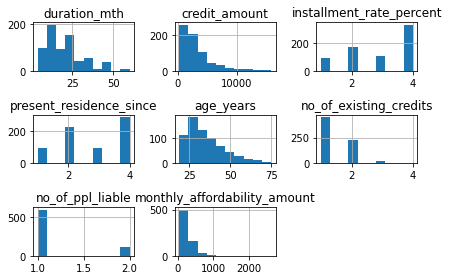

In [13]:
X_train.hist()
plt.tight_layout()
plt.show()

# Feature Engineering

In [14]:
cols = ordinal_cols + categorical_cols
categorical_cols_index = [col in cols for col in X_train.columns]

In [15]:
rare_encoder = enc.RareLabelEncoder(
    variables=categorical_cols,
    n_categories=1,
    max_n_categories=4,
    replace_with='RARE'
)

freq_encoder = enc.CountFrequencyEncoder(
    encoding_method='frequency',
    variables=categorical_cols,
)

ordinal_encoder = enc.OrdinalEncoder(
    encoding_method='ordered',
    variables=categorical_cols
)

log_transformer = trans.LogTransformer(
    variables=continuous_cols,
)

scaler = Scaler(
    transformer=StandardScaler(), 
    variables=continuous_cols
)

smote = SMOTENC(
    random_state=SEED,
    categorical_features=categorical_cols_index,
    n_jobs=-1,
    k_neighbors=100
)

## Numerical Pipeline (Log + Scaling)

In [16]:
steps = [
    ('Log Transformation', log_transformer),
    ('Standard Scaling', scaler),
]

pipeline_numeric = Pipeline(steps=steps)
pipeline_numeric.fit(X_train, y_train)

X_train_transform = pipeline_numeric.transform(X_train)
X_test_transform = pipeline_numeric.transform(X_test)

df_train_transform = pd.concat([X_train_transform, y_train], axis=1)
df_test_transform = pd.concat([X_test_transform, y_test], axis=1)

file_name = '01_pipeline_numeric'
if OUTPUT:
    output_file(file_name, df_train_transform, df_test_transform, pipeline_numeric)

Done


## SMOTE

In [17]:
steps = [
    ('SMOTENC', smote)
]
pipeline_smote = ImbPipeline(steps=steps)
X_train_smote, y_train_smote = pipeline_smote.fit_resample(X_train_transform, y_train)

df_train_smote = pd.concat([X_train_smote, y_train_smote], axis=1)

file_name = '02_pipeline_smote'
if OUTPUT:
    output_file(file_name, df_train_smote, df_test_transform, pipeline_smote)

Done


In [18]:
display(
    y_train.shape[0],
    y_train_smote.value_counts(normalize=True)
)

700

0    0.5
1    0.5
Name: label, dtype: float64

## Categorical Encoding

### Rare -> Frequency

In [19]:
steps = [
    ('Rare Encoding', rare_encoder),
    ('Frequency Encoding', freq_encoder)
]

pipeline_rare_freq = Pipeline(steps=steps)
pipeline_rare_freq.fit(X_train, y_train)

X_train_categorical = pipeline_rare_freq.transform(X_train_smote)
X_test_categorical = pipeline_rare_freq.transform(X_test_transform)

df_train_categorical = pd.concat([X_train_categorical, y_train_smote], axis=1)
df_test_categorical = pd.concat([X_test_categorical, y_test], axis=1)

file_name = '03_pipeline_rare_freq'
if OUTPUT:
    output_file(
        file_name, 
        df_train_categorical, 
        df_test_categorical, 
        pipeline_rare_freq
    )

Done


### Rare -> Ordinal

In [20]:
steps = [
    ('Rare Encoding', rare_encoder),
    ('Ordinal Encoding', ordinal_encoder)
]

pipeline_rare_ordinal = Pipeline(steps=steps)
pipeline_rare_ordinal.fit(X_train, y_train)

X_train_categorical = pipeline_rare_ordinal.transform(X_train_smote)
X_test_categorical = pipeline_rare_ordinal.transform(X_test_transform)

df_train_categorical = pd.concat([X_train_categorical, y_train_smote], axis=1)
df_test_categorical = pd.concat([X_test_categorical, y_test], axis=1)

file_name = '03_pipeline_rare_ordinal'
if OUTPUT:
    output_file(
        file_name, 
        df_train_categorical, 
        df_test_categorical, 
        pipeline_rare_ordinal
    )

Done
